In [16]:
import tensorflow as tf
tf.python.control_flow_ops = tf

import os
import pandas as pd
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, \
MaxPooling2D, Conv2D, Lambda, Cropping2D, Convolution2D,\
AveragePooling2D,Input, merge
from keras.callbacks import History,TensorBoard, EarlyStopping, ModelCheckpoint
from sklearn.cross_validation import train_test_split

from copy import deepcopy
from sklearn.utils import shuffle


from generator import generator
from get_images import get_images

from keras.optimizers import Adam


In [2]:
datadirs=['/notebooks/udacity/new_training/map1_backward/',
                 '/notebooks/udacity/new_training/map1_forward/',
                 '/notebooks/udacity/new_training/map1_recovery_backward/',
                 '/notebooks/udacity/new_training/map1_recovery_forward/',
                 '/notebooks/udacity/new_training/map2_forward/',
                 '/notebooks/udacity/new_training/map2_backward/',
                 '/notebooks/udacity/new_training/map2_recovery_forward/',
                 '/notebooks/udacity/new_training/map2_recovery_backward/',
                   '/notebooks/udacity/new_training/map1_error_correction/',
                   '/notebooks/udacity/new_training/map2_error_correction/'
         ]

#datadirs=['/notebooks/udacity/car_data/data/']

images=get_images(datadirs)

In [3]:
size=(40,80)

def preprocessing_resize(im):
    return cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2YUV),(size[1],size[0]))

def preprocessing_yuv(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2YUV)



In [4]:
from car_models import *

In [5]:
grid=[{'get_model':modified_lenet, 'correction':0.09, \
       'preprocessing':preprocessing_resize,'optimizer':Adam(lr=0.01),'gpu':'0','name':'lenet_02_adam'},\
     {'get_model':nvidia_net, 'correction':0.09, \
       'preprocessing':preprocessing_yuv,'optimizer':Adam(lr=0.01),'gpu':'0','name':'nvidia_net_02_adam'},
      {'get_model':inception, 'correction':0.09, \
       'preprocessing':lambda x:x,'optimizer':Adam(lr=0.01),'gpu':'0','name':'inception_02_adam'},
     {'get_model':vgg16, 'correction':0.09, \
       'preprocessing':lambda x:x,'optimizer':Adam(lr=0.01),'gpu':'0','name':'vgg16_02_adam'},
      ]

In [6]:
import os
import pickle

def train_model(get_model, correction, preprocessing, name, optimizer, gpu,leftright_weight=1):
    import os

    os.environ['CUDA_VISIBLE_DEVICES']=str(gpu)
    
    model=get_model()
    model.compile(loss='mse', optimizer=optimizer, metrics=['mean_squared_error'])
    
    if not os.path.exists('results/logs_%s'%name):
        os.mkdir('results/logs_%s'%name)
    
    
    checkpoint = ModelCheckpoint("results/model_%s.h5" % name, monitor='val_mean_squared_error', verbose=1,
                              save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_mean_squared_error',\
                               min_delta=0.001, patience=3,
                                verbose=1, mode='min')

    history = History()

    tb=TensorBoard(log_dir='results/logs_%s'%name, histogram_freq=0, write_graph=True, write_images=False)

    train_generator = generator(deepcopy(images), dataset=0, batch_size=32, preprocessing=preprocessing,\
                               leftright_weight=leftright_weight)
    validation_generator = generator(deepcopy(images), dataset=1, batch_size=32, preprocessing=preprocessing,\
                                    leftright_weight=leftright_weight)
    test_generator = generator(deepcopy(images), dataset=2, batch_size=32, preprocessing=preprocessing,\
                              leftright_weight=leftright_weight)

    ##todo - nb_epoch=100
    q=model.fit_generator(train_generator, \
                    samples_per_epoch=len(images[images.dataset==0]),\
                    nb_epoch=100,\
                    verbose=1,\
                    validation_data=validation_generator, \
                    nb_val_samples=len(images[images.dataset==1]),\
                    callbacks=[checkpoint, early_stop,history,tb]\
                   )
    
    f=open('results/history_%s.pk1' % name,'wb')
    pickle.dump(history.history,f,-1)
    f.close()
    
    #realy it's from last iteration - better to load best model here
    res=model.evaluate_generator(test_generator,val_samples=len(images[images.dataset==1]))[0]
    return q,res

In [20]:
def qqq1():

    # ----------------------
    # Model - ideas from VG type network
    inp = Input(shape=(160,320,3))
    
    x=Cropping2D(cropping=((60,20), (0,0)))(inp)

    x=Lambda(lambda x: (x / 255.0) - 0.5)(x)
    
    x = AveragePooling2D((2,2))(x)
    
    # First convolution is for model to determine the 'best' colorspace weights
    x = Conv2D(3, 1, 1, border_mode='same', activation='relu')(x)
    # Reduce dimensions
    x = MaxPooling2D((2,2))(x) #20x80

    # First convolution layer
    x1 = Conv2D(32, 3, 3, border_mode='same', activation='relu')(x)
    x1 = Conv2D(32, 3, 3, border_mode='same', activation='relu')(x1)
    x1 = MaxPooling2D((2,2))(x1) #10x40
    x1 = Dropout(0.5)(x1)
    flat1 = Flatten()(x1) # Used for the merge before first fully connected layer

    # Second convolution layer
    x2 = Conv2D(64, 3, 3, border_mode='same', activation='relu')(x1)
    x2 = Conv2D(64, 3, 3, border_mode='same', activation='relu')(x2)
    x2 = MaxPooling2D((2,2))(x2) #5x20
    x2 = Dropout(0.5)(x2)
    flat2 = Flatten()(x2) # Used for the merge before first fully connected layer

    # Second convolution layer
    x3 = Conv2D(64, 3, 3, border_mode='same', activation='relu')(x2)
    x3 = Conv2D(64, 3, 3, border_mode='same', activation='relu')(x3)
    x3 = MaxPooling2D((2,2))(x3) #2x10
    x3 = Dropout(0.5)(x3)
    flat3 = Flatten()(x3) # Used for the merge before first fully connected layer

    # Merge the flattened ouputs after each convolution layer
    x4 = merge([flat1, flat2, flat3], mode='concat')
    # Fully connected layers
    x5 = Dense(512, activation='relu')(x4)
    x6 = Dense(128, activation='relu')(x5)
    x7 = Dense(16, activation='relu')(x6)
    out = Dense(1, activation='linear')(x7)

    model = Model(input=inp, output=out)
    #model.summary()
    return model



In [21]:
params={'get_model':qqq1, 'correction':0.09, \
       'preprocessing':lambda x:x,'optimizer':Adam(lr=0.0001),'gpu':'1','name':'vcc009'}

In [ ]:
tmp=train_model(**params)

Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/100
191200/220488 [=========================>....] - ETA: 42s - loss: 0.0688 - mean_squared_error: 0.0688  

In [ ]:
res=[]
errs=[]
for a in grid:
    print (a)
    try:
        tmp=train_model(**a)
    except:
        errs.append(a)
        tmp=-1
    res.append(tmp)

{'correction': 0.09, 'get_model': <function modified_lenet at 0x7f2e037f5f28>, 'name': 'lenet_02_adam', 'optimizer': <keras.optimizers.Adam object at 0x7f2e032ed438>, 'preprocessing': <function preprocessing_resize at 0x7f2e035d4510>, 'gpu': '0'}
Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/100
 72576/220488 [========>.....................] - ETA: 149s - loss: 0.0957 - mean_squared_error: 0.0957 

In [1]:
%%sh

rm -r results/*

In [ ]:
res3=[train_model(**a) for a in grid]

In [7]:
%%sh

rm -r results/*

In [14]:
res[1][0].history

{'loss': [0.3437612208133512,
  0.16276085782613806,
  0.1627599917505477,
  0.16278721181594219,
  0.16278557966733498],
 'mean_squared_error': [0.3437612208133512,
  0.16276085782613806,
  0.1627599917505477,
  0.16278721181594219,
  0.16278557966733498],
 'val_loss': [0.16519475767737357,
  0.16481634419605498,
  0.16559190217672073,
  0.16507394580480547,
  0.16506405453250503],
 'val_mean_squared_error': [0.16519475767737357,
  0.16481634419605498,
  0.16559190217672073,
  0.16507394580480547,
  0.16506405453250503]}

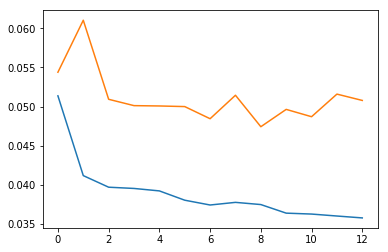

In [22]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(res[1][0].history['loss'])
plt.plot(res[1][0].history['val_loss'])



In [7]:
def nvidia_net_mod():
    """
    neural network from Nvidia paper
    """
    model=Sequential()

    model.add(Cropping2D(cropping=((50,20), (0,0)), \
                         input_shape=(160,320,3)))

    model.add(Lambda(lambda x: (x / 255.0) - 0.5))

    model.add(Convolution2D(24, 5, 5,  border_mode='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(36, 5, 5, border_mode='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.5))

    model.add(Convolution2D(48, 5, 5, border_mode='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))

    model.add(Dropout(0.5))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Flatten())


    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    return model

In [7]:
def preprocessing_yuv(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2YUV)



params={'get_model':nvidia_net, 'correction':0.08, \
       'preprocessing':preprocessing_yuv,'optimizer':Adam(lr=0.01),\
        'gpu':'0','name':'nvidia_net_mod_02_adam_smalldata'}

In [ ]:
q=train_model(**params)

Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/100
220488/220488 [==============================] - 378s - loss: 0.0667 - mean_squared_error: 0.0667 - val_loss: 0.0583 - val_mean_squared_error: 0.0583
Epoch 2/100
  9824/220488 [>.............................] - ETA: 334s - loss: 0.0603 - mean_squared_error: 0.0603

In [12]:
params={'get_model':modified_lenet, 'correction':0.2, \
       'preprocessing':preprocessing_resize,'optimizer':'adam','gpu':'0','name':'lenet_smalldata'}

In [13]:
q2=train_model(**params)

Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/100
38568/38568 [==============================] - 43s - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0660 - val_mean_squared_error: 0.0660
Epoch 2/100
38568/38568 [==============================] - 42s - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0538 - val_mean_squared_error: 0.0538
Epoch 3/100
38568/38568 [==============================] - 42s - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0471 - val_mean_squared_error: 0.0471
Epoch 4/100
38568/38568 [==============================] - 42s - loss: 0.0185 - mean_squared_error: 0.0185 - val_loss: 0.0516 - val_mean_squared_error: 0.0516
Epoch 5/100
38568/38568 [==============================] - 42s - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0419 - val_mean_squared_error: 0.0419
Epoch 6/100
38568/38568 [==============================] - 42s - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.0446 - val_mean_sq

KeyboardInterrupt: 

In [15]:
images=images[images.inverse==False]

In [16]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, ConvLSTM2D, Dense, MaxPooling2D, Dropout, Flatten, Reshape, merge, Input



def proc_img(img): # input is 160x320x3
    img = img[59:138:2, 0:-1:2, :] # select vertical region and take each second pixel to reduce image dimensions
    img = (img / 127.5) - 1.0 # normalize colors from 0-255 to -1.0 to 1.0
    return img # return 40x160x3 image


def qqq1():

    # ----------------------
    # Model - ideas from VG type network
    inp = Input(shape=(40,160,3))
    # First convolution is for model to determine the 'best' colorspace weights
    x = Conv2D(3, 1, 1, border_mode='same', activation='relu')(inp)
    # Reduce dimensions
    x = MaxPooling2D((2,2))(x) #20x80

    # First convolution layer
    x1 = Conv2D(32, 3, 3, border_mode='same', activation='relu')(x)
    x1 = Conv2D(32, 3, 3, border_mode='same', activation='relu')(x1)
    x1 = MaxPooling2D((2,2))(x1) #10x40
    x1 = Dropout(0.5)(x1)
    flat1 = Flatten()(x1) # Used for the merge before first fully connected layer

    # Second convolution layer
    x2 = Conv2D(64, 3, 3, border_mode='same', activation='relu')(x1)
    x2 = Conv2D(64, 3, 3, border_mode='same', activation='relu')(x2)
    x2 = MaxPooling2D((2,2))(x2) #5x20
    x2 = Dropout(0.5)(x2)
    flat2 = Flatten()(x2) # Used for the merge before first fully connected layer

    # Second convolution layer
    x3 = Conv2D(64, 3, 3, border_mode='same', activation='relu')(x2)
    x3 = Conv2D(64, 3, 3, border_mode='same', activation='relu')(x3)
    x3 = MaxPooling2D((2,2))(x3) #2x10
    x3 = Dropout(0.5)(x3)
    flat3 = Flatten()(x3) # Used for the merge before first fully connected layer

    # Merge the flattened ouputs after each convolution layer
    x4 = merge([flat1, flat2, flat3], mode='concat')
    # Fully connected layers
    x5 = Dense(512, activation='relu')(x4)
    x6 = Dense(128, activation='relu')(x5)
    x7 = Dense(16, activation='relu')(x6)
    out = Dense(1, activation='linear')(x7)

    model = Model(input=inp, output=out)
    #model.summary()
    return model



In [ ]:
def preprocessing_yuv(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2YUV)

params={'get_model':qqq, 'correction':0.09, \
       'preprocessing':proc_img,'optimizer':Adam(lr=0.0001),'gpu':'0','name':'fuck'}

q=train_model(**params)

Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/100
220488/220488 [==============================] - 250s - loss: 0.0650 - mean_squared_error: 0.0650 - val_loss: 0.0583 - val_mean_squared_error: 0.0583
Epoch 2/100
 97120/220488 [============>.................] - ETA: 127s - loss: 0.0548 - mean_squared_error: 0.0548

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt 

plt.plot(q[0].history['val_loss'])
plt.plot(q[0].history['loss'])
plt.show()

NameError: name 'q' is not defined

In [18]:
images[images.steering!=0].groupby('side').size()

side
-1    7350
 0    7350
 1    7350
dtype: int64

In [21]:
images[images.img.apply(lambda x:'left_2016_12_01_13_32_48_402.jpg' in x)].steering.values[0]+0.08

0.02024281

In [22]:
len(images)

24108

In [23]:
%%sh

cat /notebooks/udacity/car_data/data/driving_log.csv | wc -l

8037


In [29]:
images=images[images.side!=0]

In [44]:
images.to_pickle('images.pk1')

In [46]:

import matplotlib.image as mpimg

def generate_image_batch_tr(names, y_data, batch_size = 32):
    total_items = len(names)
    curr_item = 0
    while (True):
        image_data = np.zeros((batch_size,40, 160, 3),dtype=float)
        steering_data = np.zeros((batch_size),dtype=float)
        for j in range(batch_size):
            image_name = names[curr_item]
            image = mpimg.imread(image_name)
            image_data[j] = proc_img(image)
            steering_data[j] = y_data[curr_item]
            curr_item = (curr_item+1)%total_items
        yield image_data, steering_data

# Batch generator for validation data (in this implementation same as for training data)
def generate_image_batch(names, y_data, batch_size = 32):
    total_items = len(names)
    curr_item = 0
    while (True):
        image_data = np.zeros((batch_size,40, 160, 3),dtype=float)
        steering_data = np.zeros((batch_size),dtype=float)
        for j in range(batch_size):
            image_name = names[curr_item]
            image = mpimg.imread(image_name)
            image_data[j] = proc_img(image)
            steering_data[j] = y_data[curr_item]
            curr_item = (curr_item+1)%total_items
        yield image_data, steering_data

In [54]:
images['real']=images.steering+images.side*0.08

In [13]:
images1=images[(images.inverse==False) & (images.side!=0)]

In [55]:
names=images.img.values
y=images.real.values

In [62]:
from sklearn.utils import shuffle
names,y=shuffle(names,y)

In [63]:
names_train,names_test, y_train,y_test=train_test_split(names,y,test_size=0.1)

In [21]:
tr_gen=generate_image_batch_tr(names_train, y_train, 64)
tr_gen=generate_image_batch_tr(names_test, y_test, 64)



In [64]:
from keras.callbacks import History,TensorBoard, EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint("model.h5" , monitor='val_mean_squared_error', verbose=1,
                          save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_mean_squared_error',\
                           min_delta=0.001, patience=3,
                            verbose=1, mode='min')

# Compile, train and save
#model.compile(optimizer=Adam(lr=FLAGS.learn_rate), loss='mse')


model.compile(loss='mse', optimizer=Adam(lr=0.0001), metrics=['mean_squared_error'])


print ('Split data')
X_tr_names, X_val_names, y_tr, y_val = train_test_split(names,y,test_size=0.1)#newRandomTestValidationSplit(image_names_full, y_data_full)

print ('Start training')
# Training and validation inputs are fed from generators
# Number of samples based on data_set size and adjusted to fit batch size
history = model.fit_generator(generate_image_batch_tr(X_tr_names, y_tr, 64),samples_per_epoch=20000,
                              nb_epoch=100,
                              validation_data=generate_image_batch(X_val_names, y_val, 32),\
                             nb_val_samples=len(y_val),callbacks=[checkpoint, early_stop])


Split data
Start training
Epoch 1/100
19968/20000 [============================>.] - ETA: 0s - loss: 0.0538 - mean_squared_error: 0.0538  

/root/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_mean_squared_error improved from inf to 0.05159, saving model to model.h5
20032/20000 [==============================] - 51s - loss: 0.0537 - mean_squared_error: 0.0537 - val_loss: 0.0516 - val_mean_squared_error: 0.0516
Epoch 2/100
20032/20000 [==============================] - 49s - loss: 0.0538 - mean_squared_error: 0.0538 - val_loss: 0.0521 - val_mean_squared_error: 0.0521
Epoch 3/100
20032/20000 [==============================] - 49s - loss: 0.0502 - mean_squared_error: 0.0502 - val_loss: 0.0503 - val_mean_squared_error: 0.0503
Epoch 4/100
20032/20000 [==============================] - 50s - loss: 0.0517 - mean_squared_error: 0.0517 - val_loss: 0.0499 - val_mean_squared_error: 0.0499
Epoch 5/100
20032/20000 [==============================] - 49s - loss: 0.0509 - mean_squared_error: 0.0509 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 6/100
20032/20000 [==============================] - 49s - loss: 0.0507 - mean_squared_error: 0.0507 - val_loss: 0.0490 

In [48]:
q=generate_image_batch_tr(X_tr_names, y_tr, 64)

In [49]:
next(q)

(array([[[[-0.57647059, -0.58431373, -1.        ],
          [-0.7254902 , -0.77254902, -1.        ],
          [ 0.5372549 ,  0.46666667, -0.1372549 ],
          ..., 
          [ 0.55294118,  0.80392157,  0.89019608],
          [ 0.49019608,  0.75686275,  0.82745098],
          [ 0.6       ,  0.83529412,  0.85098039]],
 
         [[-0.74901961, -0.77254902, -1.        ],
          [-0.75686275, -0.81176471, -1.        ],
          [ 0.67058824,  0.6       ,  0.01176471],
          ..., 
          [ 0.1372549 ,  0.28627451,  0.23921569],
          [ 0.2       ,  0.35686275,  0.27058824],
          [ 0.25490196,  0.37254902,  0.22352941]],
 
         [[ 0.76470588,  0.73333333,  0.25490196],
          [ 0.70980392,  0.67058824,  0.16862745],
          [ 0.59215686,  0.52156863, -0.09803922],
          ..., 
          [-0.01176471,  0.05882353, -0.0745098 ],
          [ 0.05098039,  0.12156863, -0.04313725],
          [ 0.31764706,  0.34117647,  0.09803922]],
 
         ..., 
         [

In [35]:
np.where(names=='ebooks/udacity/car_data/data/IMG/left_2016_12_01_13_41_25_206.jpg')

(array([], dtype=int64),)

In [6]:
preprocessing=lambda x:x
leftright_weight=1

train_generator = generator(images, dataset=0, batch_size=32, preprocessing=preprocessing,\
                           leftright_weight=leftright_weight)
validation_generator = generator(images, dataset=1, batch_size=32, preprocessing=preprocessing,\
                                leftright_weight=leftright_weight)
test_generator = generator(images, dataset=2, batch_size=32, preprocessing=preprocessing,\
                          leftright_weight=leftright_weight)

In [5]:
images['side']=0
images['steering']=range(len(images))
#images=images[images.inverse]

In [7]:
next(train_generator)[1]

False
True
inverse!
False
True
inverse!
True
inverse!
False
True
inverse!
True
inverse!
False
False
False
True
inverse!
True
inverse!
True
inverse!
False
True
inverse!
True
inverse!
True
inverse!
False
True
inverse!
True
inverse!
True
inverse!
False
False
True
inverse!
True
inverse!
False
True
inverse!
False
False
True
inverse!
True
inverse!


array([-164618.,  207173.,   22620., -274665.,  100852.,  210734.,
         40422., -143831., -180491.,   15907.,     411.,  214390.,
       -169454., -139175.,  -68237.,  112692., -163911.,  -70022.,
        -89652., -240112., -161588., -164144., -178108.,   12111.,
       -179786., -272922.,    5932.,  -61449.,  118905., -165439.,
         30178., -261390.])

In [6]:
next(train_generator)[1]

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


array([ 49.,  72.,  76.,  74.,  43.,  60.,  78.,  62.,  68.,  66.,  48.,
        56.,  64.,  69.,  44.,  61.,  73.,  77.,  50.,  55.,  46.,  57.,
        81.,  42.,  47.,  70.,  80.,  52.,  71.,  53.,  67.,  58.])

In [7]:
next(train_generator)[1]

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


array([ 115.,  113.,   86.,  112.,  116.,  123.,  106.,  122.,  121.,
         97.,  114.,   82.,   83.,   99.,  120.,  110.,  100.,   98.,
        101.,   95.,   92.,   85.,  111.,   89.,   90.,   87.,   88.,
        118.,  102.,  124.,  105.,   91.])

In [9]:
images[images.inverse]

img  side  steering  \
0     /notebooks/udacity/new_training/map1_backward/...     0     45936   
1     /notebooks/udacity/new_training/map1_backward/...     0     45937   
2     /notebooks/udacity/new_training/map1_backward/...     0     45938   
3     /notebooks/udacity/new_training/map1_backward/...     0     45939   
4     /notebooks/udacity/new_training/map1_backward/...     0     45940   
5     /notebooks/udacity/new_training/map1_backward/...     0     45941   
6     /notebooks/udacity/new_training/map1_backward/...     0     45942   
7     /notebooks/udacity/new_training/map1_backward/...     0     45943   
8     /notebooks/udacity/new_training/map1_backward/...     0     45944   
9     /notebooks/udacity/new_training/map1_backward/...     0     45945   
10    /notebooks/udacity/new_training/map1_backward/...     0     45946   
11    /notebooks/udacity/new_training/map1_backward/...     0     45947   
12    /notebooks/udacity/new_training/map1_backward/...     0     45948   
13    /notebooks/udacity/new_training/map1_backward/...     0     45949   
14    /notebooks/udacity/new_training/map1_backward/...     0     45950   
15    /notebooks/udacity/new_training/map1_backward/...     0     45951   
16    /notebooks/udacity/new_training/map1_backward/...     0     45952   
17    /notebooks/udacity/new_training/map1_backward/...     0     45953   
18    /notebooks/udacity/new_training/map1_backward/...     0     45954   
19    /notebooks/udacity/new_training/map1_backward/...     0     45955   
20    /notebooks/udacity/new_training/map1_backward/...     0     45956   
21    /notebooks/udacity/new_training/map1_backward/...     0     45957   
22    /notebooks/udacity/new_training/map1_backward/...     0     45958   
23    /notebooks/udacity/new_training/map1_backward/...     0     45959   
24    /notebooks/udacity/new_training/map1_backward/...     0     45960   
25    /notebooks/udacity/new_training/map1_backward/...     0     45961   
26    /notebooks/udacity/new_training/map1_backward/...     0     45962   
27    /notebooks/udacity/new_training/map1_backward/...     0     45963   
28    /notebooks/udacity/new_training/map1_backward/...     0     45964   
29    /notebooks/udacity/new_training/map1_backward/...     0     45965   
...                                                 ...   ...       ...   
3516  /notebooks/udacity/new_training/map2_error_cor...     0    275586   
3517  /notebooks/udacity/new_training/map2_error_cor...     0    275587   
3518  /notebooks/udacity/new_training/map2_error_cor...     0    275588   
3519  /notebooks/udacity/new_training/map2_error_cor...     0    275589   
3520  /notebooks/udacity/new_training/map2_error_cor...     0    275590   
3521  /notebooks/udacity/new_training/map2_error_cor...     0    275591   
3522  /notebooks/udacity/new_training/map2_error_cor...     0    275592   
3523  /notebooks/udacity/new_training/map2_error_cor...     0    275593   
3524  /notebooks/udacity/new_training/map2_error_cor...     0    275594   
3525  /notebooks/udacity/new_training/map2_error_cor...     0    275595   
3526  /notebooks/udacity/new_training/map2_error_cor...     0    275596   
3527  /notebooks/udacity/new_training/map2_error_cor...     0    275597   
3528  /notebooks/udacity/new_training/map2_error_cor...     0    275598   
3529  /notebooks/udacity/new_training/map2_error_cor...     0    275599   
3530  /notebooks/udacity/new_training/map2_error_cor...     0    275600   
3531  /notebooks/udacity/new_training/map2_error_cor...     0    275601   
3532  /notebooks/udacity/new_training/map2_error_cor...     0    275602   
3533  /notebooks/udacity/new_training/map2_error_cor...     0    275603   
3534  /notebooks/udacity/new_training/map2_error_cor...     0    275604   
3535  /notebooks/udacity/new_training/map2_error_cor...     0    275605   
3536  /notebooks/udacity/new_training/map2_error_cor...     0    275606   
3537  /notebooks/udacity/new_training/map2_error_cor...     0    275607   
35

In [80]:
next(train_generator)[1]

array([ 195.,  183.,  165.,  186.,  179.,  175.,  174.,  162.,  197.,
        161.,  172.,  163.,  169.,  199.,  170.,  189.,  192.,  164.,
        178.,  173.,  194.,  190.,  180.,  188.,  176.,  166.,  168.,
        160.,  177.,  187.,  167.,  196.])

In [81]:
next(train_generator)[1]

array([ 231.,  234.,  232.,  211.,  206.,  228.,  233.,  200.,  235.,
        209.,  225.,  236.,  217.,  223.,  224.,  208.,  220.,  221.,
        219.,  230.,  227.,  218.,  222.,  213.,  207.,  202.,  226.,
        205.,  215.,  214.,  212.,  204.])

In [82]:
next(train_generator)[1]

array([ 253.,  261.,  237.,  245.,  250.,  272.,  270.,  273.,  254.,
        267.,  255.,  240.,  249.,  256.,  268.,  265.,  266.,  241.,
        269.,  264.,  247.,  242.,  260.,  263.,  243.,  251.,  248.,
        258.,  244.,  257.,  239.,  259.])

In [85]:
images[images.inverse]

img  side  steering  \
0     /notebooks/udacity/new_training/map1_backward/...     0     45936   
1     /notebooks/udacity/new_training/map1_backward/...     0     45937   
2     /notebooks/udacity/new_training/map1_backward/...     0     45938   
3     /notebooks/udacity/new_training/map1_backward/...     0     45939   
4     /notebooks/udacity/new_training/map1_backward/...     0     45940   
5     /notebooks/udacity/new_training/map1_backward/...     0     45941   
6     /notebooks/udacity/new_training/map1_backward/...     0     45942   
7     /notebooks/udacity/new_training/map1_backward/...     0     45943   
8     /notebooks/udacity/new_training/map1_backward/...     0     45944   
9     /notebooks/udacity/new_training/map1_backward/...     0     45945   
10    /notebooks/udacity/new_training/map1_backward/...     0     45946   
11    /notebooks/udacity/new_training/map1_backward/...     0     45947   
12    /notebooks/udacity/new_training/map1_backward/...     0     45948   
13    /notebooks/udacity/new_training/map1_backward/...     0     45949   
14    /notebooks/udacity/new_training/map1_backward/...     0     45950   
15    /notebooks/udacity/new_training/map1_backward/...     0     45951   
16    /notebooks/udacity/new_training/map1_backward/...     0     45952   
17    /notebooks/udacity/new_training/map1_backward/...     0     45953   
18    /notebooks/udacity/new_training/map1_backward/...     0     45954   
19    /notebooks/udacity/new_training/map1_backward/...     0     45955   
20    /notebooks/udacity/new_training/map1_backward/...     0     45956   
21    /notebooks/udacity/new_training/map1_backward/...     0     45957   
22    /notebooks/udacity/new_training/map1_backward/...     0     45958   
23    /notebooks/udacity/new_training/map1_backward/...     0     45959   
24    /notebooks/udacity/new_training/map1_backward/...     0     45960   
25    /notebooks/udacity/new_training/map1_backward/...     0     45961   
26    /notebooks/udacity/new_training/map1_backward/...     0     45962   
27    /notebooks/udacity/new_training/map1_backward/...     0     45963   
28    /notebooks/udacity/new_training/map1_backward/...     0     45964   
29    /notebooks/udacity/new_training/map1_backward/...     0     45965   
...                                                 ...   ...       ...   
3516  /notebooks/udacity/new_training/map2_error_cor...     0    275586   
3517  /notebooks/udacity/new_training/map2_error_cor...     0    275587   
3518  /notebooks/udacity/new_training/map2_error_cor...     0    275588   
3519  /notebooks/udacity/new_training/map2_error_cor...     0    275589   
3520  /notebooks/udacity/new_training/map2_error_cor...     0    275590   
3521  /notebooks/udacity/new_training/map2_error_cor...     0    275591   
3522  /notebooks/udacity/new_training/map2_error_cor...     0    275592   
3523  /notebooks/udacity/new_training/map2_error_cor...     0    275593   
3524  /notebooks/udacity/new_training/map2_error_cor...     0    275594   
3525  /notebooks/udacity/new_training/map2_error_cor...     0    275595   
3526  /notebooks/udacity/new_training/map2_error_cor...     0    275596   
3527  /notebooks/udacity/new_training/map2_error_cor...     0    275597   
3528  /notebooks/udacity/new_training/map2_error_cor...     0    275598   
3529  /notebooks/udacity/new_training/map2_error_cor...     0    275599   
3530  /notebooks/udacity/new_training/map2_error_cor...     0    275600   
3531  /notebooks/udacity/new_training/map2_error_cor...     0    275601   
3532  /notebooks/udacity/new_training/map2_error_cor...     0    275602   
3533  /notebooks/udacity/new_training/map2_error_cor...     0    275603   
3534  /notebooks/udacity/new_training/map2_error_cor...     0    275604   
3535  /notebooks/udacity/new_training/map2_error_cor...     0    275605   
3536  /notebooks/udacity/new_training/map2_error_cor...     0    275606   
3537  /notebooks/udacity/new_training/map2_error_cor...     0    275607   
35